### Veri  Setinin Yüklenmesi

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

train_dir = 'training_set'
valid_dir = 'valid_set'
test_dir = 'test_set'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(256,256),
                                                   batch_size=8,
                                                   class_mode='binary')
validation_generator = test_datagen.flow_from_directory(valid_dir,
                                                   target_size=(256,256),
                                                   batch_size=8,
                                                   class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=(256,256),
                                                   batch_size=8,
                                                   class_mode='binary')

Found 200 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


### veri ve etiketlerin boyutlarinin ciktilari

In [3]:
for data_batch, labels_batch in train_generator:
    print('data batch shape', data_batch.shape)
    print('labels batch shape', labels_batch.shape)
    break

for data, label in test_generator:
    break

data batch shape (8, 256, 256, 3)
labels batch shape (8,)


In [331]:
print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

{'moveHub': 0, 'moveWindow': 1}


### Xception mimarisinin tanimlanmasi ve agirliklarin yuklenmesi

In [43]:
from keras.applications import Xception

conv_base = Xception(weights='imagenet',
                    include_top = False,
                    input_shape=(256,256,3))


### Mimarinin sablon ciktilari

In [179]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Veri setindeki resimlerin ozellik haritasinin cikarilmasi

In [47]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 8

def extract_features(directory, sample_count):
    features =np.zeros(shape=(sample_count,8,8,2048))
    labels =np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(directory,
                                           target_size=(256,256),
                                           batch_size= batch_size,
                                           class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
    
    
        if i * batch_size >= sample_count:
            break
            
    return features, labels

       
import tensorflow as tf

with tf.device("cpu:0"):
    print("CPU calisiyor")

    train_features, train_labels = extract_features(train_dir, 200)
    validation_features, validation_labels = extract_features(valid_dir, 16)
    test_features, test_labels = extract_features(test_dir, 24)


CPU calisiyor
Found 200 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


### 1.Egitim

CPU calisiyor
Train on 200 samples, validate on 16 samples
Epoch 1/5
200/200 [==============================] - 1s 5ms/step - loss: 0.4317 - acc: 0.7750 - precision_20: 0.6451 - recall_20: 0.6227 - val_loss: 0.1739 - val_acc: 0.9375 - val_precision_20: 0.7951 - val_recall_20: 0.7689
Epoch 2/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0902 - acc: 0.9950 - precision_20: 0.8618 - recall_20: 0.8405 - val_loss: 0.0437 - val_acc: 1.0000 - val_precision_20: 0.8957 - val_recall_20: 0.8832
Epoch 3/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0254 - acc: 1.0000 - precision_20: 0.9146 - recall_20: 0.9041 - val_loss: 0.0236 - val_acc: 1.0000 - val_precision_20: 0.9310 - val_recall_20: 0.9224
Epoch 4/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0132 - acc: 1.0000 - precision_20: 0.9403 - recall_20: 0.9327 - val_loss: 0.0216 - val_acc: 1.0000 - val_precision_20: 0.9485 - val_recall_20: 0.9419
Epoch 5/5
200/200 [======================

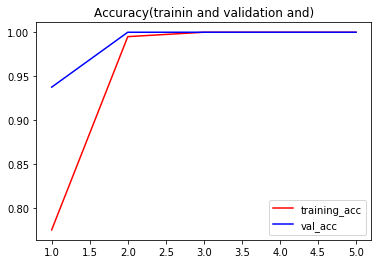

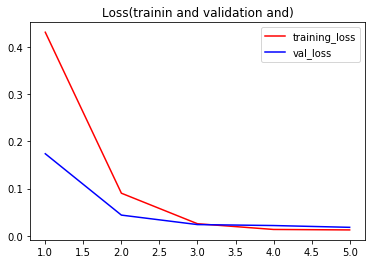

In [34]:
with tf.device("cpu:0"):
    print("CPU calisiyor")
    
    model = models.Sequential()
    model.add(layers.GlobalAvgPool2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, activation = 'relu', input_dim =8*8*2048))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(),
                 loss='binary_crossentropy',
                 metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    hist = model.fit(train_features, train_labels, epochs=5, batch_size=8,
                        validation_data=(validation_features,validation_labels))

#test_gen = test_datagen.flow_from_directory(test_dir, target_size=(256,256), batch_size=8, class_mode='binary')
#scores = model.evaluate_generator(test_gen)
#test_acc = scores[1]
#test_loss = scores[0]
#print("test accuracy", test_acc)
#print("test_loss", test_loss)


import matplotlib.pyplot as plt
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) +1 )
plt.plot(epochs, acc, 'r', label='training_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Accuracy(trainin and validation and)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Loss(trainin and validation and)')
plt.legend()

plt.show()

### 2.  Egitim 1.kisim(Adam)

In [68]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAvgPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation = 'relu', input_dim =8*8*2048))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(),
                 loss='binary_crossentropy',
                 metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
history = model.fit_generator(train_generator, epochs=5, validation_data=validation_generator)
        
test_gen = test_datagen.flow_from_directory(test_dir, target_size=(256,256), batch_size=8, class_mode='binary')
scores = model.evaluate_generator(test_gen)
test_acc = scores[1]
test_loss = scores[0]
print("test accuracy", test_acc)
print("test_loss", test_loss)



Epoch 1/5
25/25 [==============================] - 91s 4s/step - loss: 0.0548 - acc: 0.9900 - precision_24: 0.9600 - recall_24: 0.8977 - val_loss: 0.1320 - val_acc: 0.9375 - val_precision_24: 1.0000 - val_recall_24: 0.9763
Epoch 2/5
25/25 [==============================] - 85s 3s/step - loss: 9.5665e-05 - acc: 1.0000 - precision_24: 1.0000 - recall_24: 0.9807 - val_loss: 1.2737e-04 - val_acc: 0.9375 - val_precision_24: 1.0000 - val_recall_24: 0.9814
Epoch 3/5
25/25 [==============================] - 90s 4s/step - loss: 4.2696e-05 - acc: 1.0000 - precision_24: 1.0000 - recall_24: 0.9849 - val_loss: 0.0800 - val_acc: 0.9375 - val_precision_24: 1.0000 - val_recall_24: 0.9845
Epoch 4/5
25/25 [==============================] - 86s 3s/step - loss: 2.7736e-04 - acc: 1.0000 - precision_24: 1.0000 - recall_24: 0.9866 - val_loss: 0.0179 - val_acc: 0.9375 - val_precision_24: 1.0000 - val_recall_24: 0.9861
Epoch 5/5
25/25 [==============================] - 86s 3s/step - loss: 7.6860e-05 - acc: 1.0

0. epoch 
 precision:0.9599999785423279, recall:0.8977335095405579, acc:0.9900000095367432, val_acc:0.9375, loss:0.0548291058545874, val_loss:0.13195069134235382, f1_score:0.9278232455253601
1. epoch 
 precision:1.0, recall:0.980680525302887, acc:1.0, val_acc:0.9375, loss:9.566548759721627e-05, val_loss:0.00012736913049593568, f1_score:0.990246057510376
2. epoch 
 precision:1.0, recall:0.9848787188529968, acc:1.0, val_acc:0.9375, loss:4.2695612023635476e-05, val_loss:0.08002695441246033, f1_score:0.992381751537323
3. epoch 
 precision:1.0, recall:0.9865828156471252, acc:1.0, val_acc:0.9375, loss:0.00027735865169052686, val_loss:0.017850954085588455, f1_score:0.9932461380958557
4. epoch 
 precision:1.0, recall:0.9874849915504456, acc:1.0, val_acc:0.9375, loss:7.685960485197541e-05, val_loss:0.01698773168027401, f1_score:0.9937031269073486


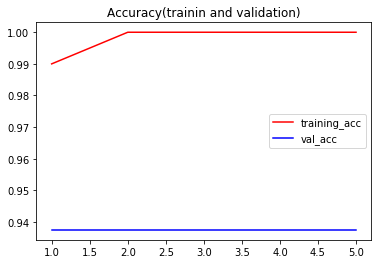

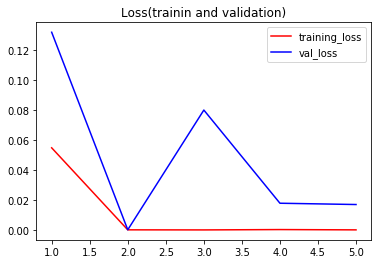

In [71]:
for i in range(0,5):
    precision = history.history['precision_24'][i]
    recall = history.history['recall_24'][i]
    acc = history.history['acc'][i]
    val_acc = history.history['val_acc'][i]
    loss = history.history['loss'][i]
    val_loss = history.history['val_loss'][i]
    f1_score = 2 * ((precision*recall) / (precision+recall))
    print("{}. epoch \n precision:{}, recall:{}, acc:{}, val_acc:{}, loss:{}, val_loss:{}, f1_score:{}".format(
    i,precision,recall,acc,val_acc,loss,val_loss,f1_score))
    
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1 )
plt.plot(epochs, acc, 'r', label='training_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Accuracy(trainin and validation)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Loss(trainin and validation)')
plt.legend()

plt.show()


### 2.  Egitim 2.kisim(SGD (lr: 0.0001, momentum: 0.7))

In [72]:
with tf.device("cpu:0"):
    print("CPU calisiyor")
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAvgPool2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, activation = 'relu', input_dim =8*8*2048))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(optimizer=optimizers.SGD(learning_rate=0.0001,momentum=0.7),
                 loss='binary_crossentropy',
                 metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

    history = model.fit_generator(train_generator, epochs=5, validation_data=validation_generator)

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(256,256), batch_size=8, class_mode='binary')
scores = model.evaluate_generator(test_gen)
test_acc = scores[1]
test_loss = scores[0]
print("test accuracy", test_acc)
print("test_loss", test_loss)
    


CPU calisiyor
Epoch 1/5
25/25 [==============================] - 88s 4s/step - loss: 0.7061 - acc: 0.4900 - precision_25: 0.4626 - recall_25: 0.7955 - val_loss: 0.6830 - val_acc: 0.5625 - val_precision_25: 0.4955 - val_recall_25: 0.7869
Epoch 2/5
25/25 [==============================] - 81s 3s/step - loss: 0.6554 - acc: 0.6000 - precision_25: 0.5036 - recall_25: 0.8012 - val_loss: 0.6615 - val_acc: 0.8125 - val_precision_25: 0.5331 - val_recall_25: 0.8310
Epoch 3/5
25/25 [==============================] - 82s 3s/step - loss: 0.6098 - acc: 0.7450 - precision_25: 0.5570 - recall_25: 0.8462 - val_loss: 0.6416 - val_acc: 0.8125 - val_precision_25: 0.5806 - val_recall_25: 0.8556
Epoch 4/5
25/25 [==============================] - 82s 3s/step - loss: 0.5795 - acc: 0.8650 - precision_25: 0.6073 - recall_25: 0.8712 - val_loss: 0.6491 - val_acc: 0.8125 - val_precision_25: 0.6283 - val_recall_25: 0.8788
Epoch 5/5
25/25 [==============================] - 83s 3s/step - loss: 0.5583 - acc: 0.8900 - 

0. epoch 
 precision:0.46264970302581787, recall:0.7955451011657715, acc:0.49000000953674316, val_acc:0.5625, loss:0.7061042499542236, val_loss:0.6829856038093567, f1_score:0.5850583910942078
1. epoch 
 precision:0.503618061542511, recall:0.8012209534645081, acc:0.6000000238418579, val_acc:0.8125, loss:0.6553731799125672, val_loss:0.6615228056907654, f1_score:0.618481457233429
2. epoch 
 precision:0.557019829750061, recall:0.8462303280830383, acc:0.7450000047683716, val_acc:0.8125, loss:0.6097617626190186, val_loss:0.6416188478469849, f1_score:0.6718218326568604
3. epoch 
 precision:0.6072608828544617, recall:0.871218740940094, acc:0.8650000095367432, val_acc:0.8125, loss:0.5794538342952729, val_loss:0.6491173505783081, f1_score:0.7156772017478943
4. epoch 
 precision:0.6444023251533508, recall:0.8849998712539673, acc:0.8899999856948853, val_acc:0.875, loss:0.558282927274704, val_loss:0.6304933428764343, f1_score:0.7457762956619263


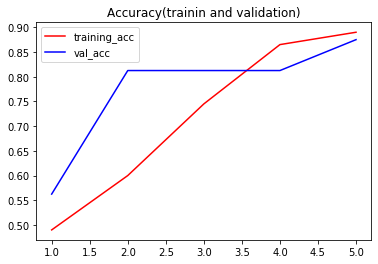

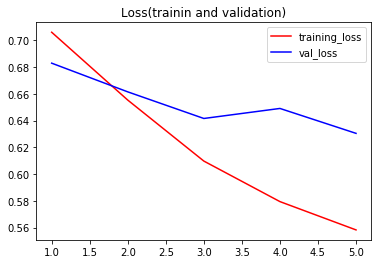

In [79]:
for i in range(0,5):
    precision = history.history['precision_25'][i]
    recall = history.history['recall_25'][i]
    acc = history.history['acc'][i]
    val_acc = history.history['val_acc'][i]
    loss = history.history['loss'][i]
    val_loss = history.history['val_loss'][i]
    f1_score = 2 * ((precision*recall) / (precision+recall))
    print("{}. epoch \n precision:{}, recall:{}, acc:{}, val_acc:{}, loss:{}, val_loss:{}, f1_score:{}".format(
    i,precision,recall,acc,val_acc,loss,val_loss,f1_score))

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']    
epochs = range(1, len(acc) +1 )
plt.plot(epochs, acc, 'r', label='training_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Accuracy(trainin and validation)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Loss(trainin and validation)')
plt.legend()

plt.show()

### 2. Egitim 3.kisim(SGD (lr: 0.0001, momentum: 0.9))

In [81]:
with tf.device("cpu:0"):
    print("CPU calisiyor")
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAvgPool2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, activation = 'relu', input_dim =8*8*2048))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(optimizer=optimizers.SGD(learning_rate=0.0001,momentum=0.9),
                 loss='binary_crossentropy',
                 metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

    history = model.fit_generator(train_generator, epochs=5, validation_data=validation_generator)

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(256,256), batch_size=8, class_mode='binary')
scores = model.evaluate_generator(test_gen)
test_acc = scores[1]
test_loss = scores[0]
print("test accuracy", test_acc)
print("test_loss", test_loss)  


CPU calisiyor
Epoch 1/5
25/25 [==============================] - 94s 4s/step - loss: 0.7255 - acc: 0.4200 - precision_27: 0.3856 - recall_27: 0.5893 - val_loss: 0.6849 - val_acc: 0.4375 - val_precision_27: 0.4371 - val_recall_27: 0.6141
Epoch 2/5
25/25 [==============================] - 88s 4s/step - loss: 0.5783 - acc: 0.8150 - precision_27: 0.5186 - recall_27: 0.6815 - val_loss: 0.6398 - val_acc: 0.9375 - val_precision_27: 0.5948 - val_recall_27: 0.7494
Epoch 3/5
25/25 [==============================] - 87s 3s/step - loss: 0.4591 - acc: 0.9750 - precision_27: 0.6552 - recall_27: 0.7944 - val_loss: 0.5571 - val_acc: 0.9375 - val_precision_27: 0.7018 - val_recall_27: 0.8261
Epoch 4/5
25/25 [==============================] - 87s 3s/step - loss: 0.3934 - acc: 0.9950 - precision_27: 0.7394 - recall_27: 0.8492 - val_loss: 0.5607 - val_acc: 0.9375 - val_precision_27: 0.7670 - val_recall_27: 0.8661
Epoch 5/5
25/25 [==============================] - 87s 3s/step - loss: 0.3279 - acc: 1.0000 - 

0. epoch 
 precision:0.38564690947532654, recall:0.5893272757530212, acc:0.41999998688697815, val_acc:0.4375, loss:0.7255130672454834, val_loss:0.6849409341812134, f1_score:0.46621182560920715
1. epoch 
 precision:0.518582284450531, recall:0.6814658641815186, acc:0.8149999976158142, val_acc:0.9375, loss:0.578271757364273, val_loss:0.6398162245750427, f1_score:0.588969886302948
2. epoch 
 precision:0.6551900506019592, recall:0.7943938970565796, acc:0.9750000238418579, val_acc:0.9375, loss:0.45913087964057925, val_loss:0.5570554137229919, f1_score:0.718108057975769
3. epoch 
 precision:0.7393797039985657, recall:0.8492351770401001, acc:0.9950000047683716, val_acc:0.9375, loss:0.3933657109737396, val_loss:0.5606880187988281, f1_score:0.7905091047286987


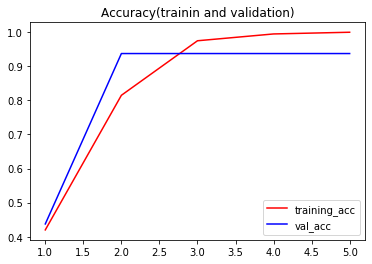

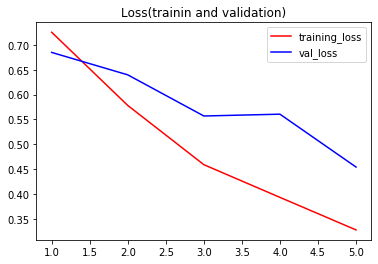

In [85]:

for i in range(0,4):
    precision = history.history['precision_27'][i]
    recall = history.history['recall_27'][i]
    acc = history.history['acc'][i]
    val_acc = history.history['val_acc'][i]
    loss = history.history['loss'][i]
    val_loss = history.history['val_loss'][i]
    f1_score = 2 * ((precision*recall) / (precision+recall))
    print("{}. epoch \n precision:{}, recall:{}, acc:{}, val_acc:{}, loss:{}, val_loss:{}, f1_score:{}".format(
    i,precision,recall,acc,val_acc,loss,val_loss,f1_score))
    
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1 )
plt.plot(epochs, acc, 'r', label='training_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Accuracy(trainin and validation)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Loss(trainin and validation)')
plt.legend()

plt.show()


### 2. Egitim 4.kisim(SGD (lr: 0.0001, momentum: 0.98))

In [86]:
with tf.device("cpu:0"):
    print("CPU calisiyor")
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAvgPool2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, activation = 'relu', input_dim =8*8*2048))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(optimizer=optimizers.SGD(learning_rate=0.0001,momentum=0.98),
                 loss='binary_crossentropy',
                 metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

    history = model.fit_generator(train_generator, epochs=5, validation_data=validation_generator)

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(256,256), batch_size=8, class_mode='binary')
scores = model.evaluate_generator(test_gen)
test_acc = scores[1]
test_loss = scores[0]
print("test accuracy", test_acc)
print("test_loss", test_loss)  


CPU calisiyor
Epoch 1/5
25/25 [==============================] - 88s 4s/step - loss: 0.5870 - acc: 0.8100 - precision_28: 0.8206 - recall_28: 0.6343 - val_loss: 0.5495 - val_acc: 0.9375 - val_precision_28: 0.8695 - val_recall_28: 0.7476
Epoch 2/5
25/25 [==============================] - 82s 3s/step - loss: 0.3608 - acc: 0.9750 - precision_28: 0.9066 - recall_28: 0.8049 - val_loss: 0.4572 - val_acc: 0.9375 - val_precision_28: 0.9332 - val_recall_28: 0.8501
Epoch 3/5
25/25 [==============================] - 81s 3s/step - loss: 0.2023 - acc: 1.0000 - precision_28: 0.9471 - recall_28: 0.8794 - val_loss: 0.4855 - val_acc: 0.9375 - val_precision_28: 0.9570 - val_recall_28: 0.8989
Epoch 4/5
25/25 [==============================] - 82s 3s/step - loss: 0.1277 - acc: 1.0000 - precision_28: 0.9632 - recall_28: 0.9116 - val_loss: 0.4044 - val_acc: 0.9375 - val_precision_28: 0.9682 - val_recall_28: 0.9220
Epoch 5/5
25/25 [==============================] - 81s 3s/step - loss: 0.0837 - acc: 1.0000 - 

0. epoch 
 precision:0.8206305503845215, recall:0.6343379616737366, acc:0.8100000023841858, val_acc:0.9375, loss:0.5869547545909881, val_loss:0.5494952201843262, f1_score:0.7155579328536987
1. epoch 
 precision:0.9066012501716614, recall:0.8048859238624573, acc:0.9750000238418579, val_acc:0.9375, loss:0.36077226519584654, val_loss:0.45722538232803345, f1_score:0.8527210354804993
2. epoch 
 precision:0.947146475315094, recall:0.8793544173240662, acc:1.0, val_acc:0.9375, loss:0.20233741760253907, val_loss:0.485469788312912, f1_score:0.9119923710823059
3. epoch 
 precision:0.9632000923156738, recall:0.9116227030754089, acc:1.0, val_acc:0.9375, loss:0.1277215775847435, val_loss:0.4043908417224884, f1_score:0.9367018938064575


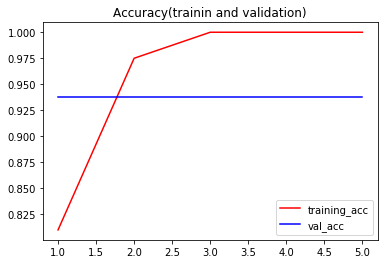

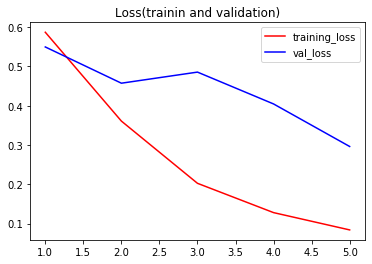

In [88]:

for i in range(0,4):
    precision = history.history['precision_28'][i]
    recall = history.history['recall_28'][i]
    acc = history.history['acc'][i]
    val_acc = history.history['val_acc'][i]
    loss = history.history['loss'][i]
    val_loss = history.history['val_loss'][i]
    f1_score = 2 * ((precision*recall) / (precision+recall))
    print("{}. epoch \n precision:{}, recall:{}, acc:{}, val_acc:{}, loss:{}, val_loss:{}, f1_score:{}".format(
    i,precision,recall,acc,val_acc,loss,val_loss,f1_score))
    
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1 )
plt.plot(epochs, acc, 'r', label='training_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Accuracy(trainin and validation)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Loss(trainin and validation)')
plt.legend()

plt.show()

### Performans karsilastirmasi

    1 - (SGD (lr: 0.0001, momentum: 0.98)
    2 - (Adam)
    3 - (SGD (lr: 0.0001, momentum: 0.9))
    4 - (SGD (lr: 0.0001, momentum: 0.7))